In [1]:
import utils, models
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Reading and Preparing Data

In [2]:
loader = utils.data_loader('./Data/ferdosi.txt')
(X, Y) = loader.get_data()

In [3]:
idx = np.random.permutation(X.shape[0])
X, Y = X[idx, :], Y[idx, :]
test_ratio = 0.1
valid_ratio = 0.1
cut1 = int(X.shape[0] * (1-test_ratio-valid_ratio))
cut2 = int(X.shape[0] * (1-test_ratio))
X_train, Y_train = X[:cut1, :], Y[:cut1, :]
X_valid, Y_valid = X[cut1:cut2, :], Y[cut1:cut2, :]
X_test, Y_test = X[cut2:, :], Y[cut2:, :]

data = {'X_train':X_train, 'Y_train':Y_train,
        'X_valid':X_valid, 'Y_valid':Y_valid,
        'X_test':X_test, 'Y_test':Y_test}

# Parameters

In [4]:
params={
  'BATCH_SIZE' : 256,
  'EPOCHS' : 150,
  'VOCAB_SIZE' : loader.n_chars,
  'MAX_LEN' : loader.max_size,
  'EMBEDDING_SIZE' : 32,
  'HIDDEN_SIZE' : 256,
  'N_LAYERS' : 1,
  'BEGIN_CHAR' : loader.all_chars_dic['_BOM_'],
  'LR' : 1e-3,
  'LR_DECAY' : 1,
  'LR_DECAY_STEP' : 20,
  'LR_MIN': 1e-5,
  'EPS' : 1,
  'EPS_DECAY' : 0.95,
  'EPS_DECAY_STEP' : 30,
  'EPS_MIN' : .8
}

# Training Function

In [5]:
def train(model, data, params, print_every=10):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    num_of_batches = np.ceil(data['X_train'].shape[0] / params['BATCH_SIZE'])
  
    loss_history = []
  
    for epoch in range(1, params['EPOCHS']+1):
        epoch_loss = 0
      
        if epoch % params['LR_DECAY_STEP'] == 0: params['LR'] *= params['LR_DECAY']
        if epoch % params['EPS_DECAY_STEP'] == 0: params['EPS'] = max(params['EPS_MIN'], params['EPS'] * params['EPS_DECAY'])
        
        for i in range(0, data['X_train'].shape[0],  params['BATCH_SIZE']):
            X_b = data['X_train'][i:i+params['BATCH_SIZE']]
            Y_b = data['Y_train'][i:i+params['BATCH_SIZE']]

            _, loss = sess.run([model.opt, model.loss], feed_dict={model.input_data: X_b, 
                                                                   model.target_data: Y_b,
                                                                   model.learning_rate: params['LR'],
                                                                   model.teacher_forcing: params['EPS']})
            epoch_loss += loss / num_of_batches
    loss_history.append(epoch_loss)
    if epoch % print_every == 0:
        print("Epoch {}, Loss:{}".format(epoch, epoch_loss))
        idx = np.random.randint(0, data['X_valid'].shape[0])
        pred = sess.run(model.prediction, feed_dict={model.input_data: data['X_valid'][idx].reshape(1, -1),
                                                     model.target_data: data['Y_valid'][idx].reshape(1, -1),
                                                     model.teacher_forcing: 0})[0]
        print('random completed poem from validation set:')
        print((loader.tensor2line(data['X_valid'][idx], False) + "  ****  " + loader.tensor2line(pred, False)))
        print('-'*100)
    return sess, loss_history

# Encoer-Decoder Model

Using Teacher Forcing with Scheduler Sampling

Epoch 10, Loss:1.0620739360650373
random completed poem from validation set:
هوا پود گشت ابر چون تار شد  ****  به دیدار بر داد بر در شدرد
----------------------------------------------------------------------------------------------------
Epoch 20, Loss:0.9111200402944513
random completed poem from validation set:
بدو گفت هرمز که در پای زهر  ****  به درد اندر امد به دل بر دهر
----------------------------------------------------------------------------------------------------
Epoch 30, Loss:0.9842609963737996
random completed poem from validation set:
زنی بود برسان گردی سوار  ****  به داد و به ایران بدین ماندار
----------------------------------------------------------------------------------------------------
Epoch 40, Loss:0.8917939628546051
random completed poem from validation set:
بیاراستند از برش تخت عاج  ****  به ایران به دیدار او بر به راج
----------------------------------------------------------------------------------------------------
Epoch 50, Loss:0.8468252353561231
random

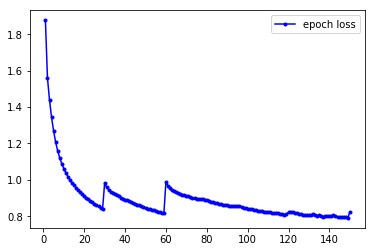

In [6]:
tf.reset_default_graph()

embedding = models.Embedding(params['VOCAB_SIZE'], params['EMBEDDING_SIZE'])
encoder = models.EncoderRNN(params['VOCAB_SIZE'], params['HIDDEN_SIZE'], params['N_LAYERS'])
decoder = models.DecoderRNN(params['VOCAB_SIZE'], params['HIDDEN_SIZE'], params['VOCAB_SIZE'], params['N_LAYERS'])
model  = models.Seq2SeqModel(encoder, decoder, embedding, params['MAX_LEN'], params['BEGIN_CHAR'])

model_sess, loss_history = train(model, data, params.copy())
test_loss = model_sess.run(model.loss, feed_dict={model.input_data: data['X_test'], 
                                                  model.target_data: data['Y_test'],
                                                  model.teacher_forcing: 0})
print('Test Loss:', test_loss)
plt.plot(range(1, params['EPOCHS']+1), loss_history, '-b.',label='epoch loss')
plt.legend()
plt.show()

# Encoer-Decoder with Attention Model 

Using Teacher Forcing with Scheduler Sampling

Epoch 10, Loss:1.2290927378030927
random completed poem from validation set:
بدیدش مر او را چو نزدیک شد  ****  به بینی به بینی به بینی به باد
----------------------------------------------------------------------------------------------------
Epoch 20, Loss:1.0483119319646788
random completed poem from validation set:
چو بر نامه بر مهر بنهاد شاه  ****  به بیداد بر بی به بی رنج بود
----------------------------------------------------------------------------------------------------
Epoch 30, Loss:1.0403051582666543
random completed poem from validation set:
بایران گذارم بر و بوم و رخت  ****  به بار اندرون کرده بر بر نهاد
----------------------------------------------------------------------------------------------------
Epoch 40, Loss:0.9137224310483689
random completed poem from validation set:
که خسرو بهر کار پیروز باد  ****  به بیداد بر کشته بر کارزار
----------------------------------------------------------------------------------------------------
Epoch 50, Loss:0.8558801168050524


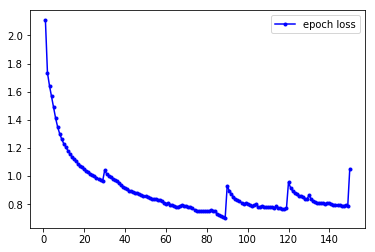

In [7]:
tf.reset_default_graph()

embedding = models.Embedding(params['VOCAB_SIZE'], params['EMBEDDING_SIZE'])
encoder = models.EncoderRNN(params['VOCAB_SIZE'], params['HIDDEN_SIZE'], params['N_LAYERS'])
attn_decoder = models.AttnDecoderRNN(params['VOCAB_SIZE'], params['HIDDEN_SIZE'], params['VOCAB_SIZE'], params['N_LAYERS'])
attn_model  = models.Seq2SeqModel(encoder, attn_decoder, embedding, params['MAX_LEN'], params['BEGIN_CHAR'])

attn_model_sess, loss_history = train(attn_model, data, params.copy())
test_loss = attn_model_sess.run(attn_model.loss, feed_dict={attn_model.input_data: data['X_test'], 
                                                       attn_model.target_data: data['Y_test'],
                                                       attn_model.teacher_forcing: 0})
print('Test Loss:', test_loss)
plt.plot(range(1, params['EPOCHS']+1), loss_history, '-b.',label='epoch loss')
plt.legend()
plt.show()

# Test and Visualization

In [8]:
import matplotlib.cm as cm

def print_weight(c, line, vals):
    cmap = cm.get_cmap('Reds')
    token = c if c != " " else "ـ"
    char_tag = "<span>" + token + "</span>"
    space_tag = "<span>\t\t:\t\t</span>"
    line_tag = ""
    for i in range(len(line)):
        r, g, b, _ = cmap(vals[i])
        r, g, b = int(255*r), int(255*g), int(255*b)
        rgb = str(r)+","+str(g)+","+str(b)
        line_tag += ("<span style='background-color: rgb({0})'>" + line[i] + "</span>").format(rgb)
    tag = "<div>" + line_tag + space_tag + char_tag + "</div>"
    return tag

In [9]:
from IPython.core.display import display, HTML

for i in range(5):
    idx = np.random.randint(0, data['X_test'].shape[0])
    pred = model_sess.run(model.prediction, feed_dict={model.input_data: data['X_test'][idx].reshape(1, -1),
                                                     model.target_data: data['Y_test'][idx].reshape(1, -1),
                                                     model.teacher_forcing: 0})
  
    attn_pred, weights = attn_model_sess.run([attn_model.prediction, attn_model.attn_weights], 
                                           feed_dict={attn_model.input_data: data['X_test'][idx].reshape(1, -1),
                                                      attn_model.target_data: data['Y_test'][idx].reshape(1, -1),
                                                      attn_model.teacher_forcing: 0})
    first_h = loader.tensor2line(data['X_test'][idx], False)
    second_h_true = loader.tensor2line(data['Y_test'][idx], False)
    second_h_1 = loader.tensor2line(pred[0], False)
    second_h_2 = loader.tensor2line(attn_pred[0], False)
  
    print('Test input:')
    print(first_h + "  ****  " + second_h_true)
  
    print('Seq2Seq output:')
    print(second_h_1)
  
    print('Seq2Seq with attention output:')
    print(second_h_2)
    print('Weights of attention:')
    for i in range(len(second_h_2)):
        tags = print_weight(second_h_2[i], first_h, weights[i, 0, weights.shape[2] - len(first_h) -1:-1])
        display(HTML(tags))

  

Test input:
کنون چاره ای هست نزدیک من  ****  مگو این سخن بر سر انجمن
Seq2Seq output:
ببردند پس پیش این انجمن
Seq2Seq with attention output:
به از  به کنداوران مر بهن
Weights of attention:


Test input:
هوا پاک دیدم ز پرندگان  ****  همان روی گیتی ز درندگان
Seq2Seq output:
به در بر زریده ز برگش گمان
Seq2Seq with attention output:
به با ار او را نگه کرد ران
Weights of attention:


Test input:
درستست گفتار فرزانگان  ****  جهاندیده و پاک دانندگان
Seq2Seq output:
که این راد و بی ار و با را زمان
Seq2Seq with attention output:
به از  به کردار نیکی نگان
Weights of attention:


Test input:
چنین گفت با رستم شیرمرد  ****  که برخیز و از خرمی بازگرد
Seq2Seq output:
که این بد که با اا بدین کار سرد
Seq2Seq with attention output:
که ای ر کمر بر کنار افر کرد
Weights of attention:


Test input:
همی تاختند از پس اردشیر  ****  به پیش اندرون اردوان و وزیر
Seq2Seq output:
سپاهی مگر با   و با ار زیر
Seq2Seq with attention output:
به از ر به کردار دریاه پیر
Weights of attention:


Test input:
به بخشش چو ابری بود دربار  ****  بود پیش او گنج دینار خوار
Seq2Seq output:
بپرسیدش از ایزگ و شوزگار
Seq2Seq with attention output:
به با ن به گفتار با باز و بار
Weights of attention:


Test input:
یکی تاج با گوهر شاهوار  ****  یکی طوق زرین زبرجد نگار
Seq2Seq output:
بیاورد با گردش روزگار
Seq2Seq with attention output:
به با د به کردار دریای کار
Weights of attention:


Test input:
نه چون اردشیر اردوان را بکشت  ****  بنیرو شد و تختش امد بمشت
Seq2Seq output:
نگر تا چه باشی به دانش بکشت
Seq2Seq with attention output:
به از  به دیده به اواز و بشت
Weights of attention:


Test input:
بفرمود کز پیش بیرون برند  ****  بسی چاره جویند و افسون برند
Seq2Seq output:
همه ساله زار جهان بر برند
Seq2Seq with attention output:
به بدزند با نامور پهلوا
Weights of attention:


Test input:
گرین کودک خرد خوی پدر  ****  نگیرد شو خسروی دادگر
Seq2Seq output:
که این راز با مو بدین بر به سر
Seq2Seq with attention output:
به با ار او را به پیوند بر
Weights of attention:


Test input:
تو دانی که من چند کوشیده ام  ****  که تا رازهای تو پوشیده ام
Seq2Seq output:
به ایرانیان بر ز ایران مهد
Seq2Seq with attention output:
به از را به کاری کند کهتر ام
Weights of attention:


Test input:
شما را ستایش فزونست ازان  ****  خروش و نیایش فزونست ازان
Seq2Seq output:
نجوید همی از تو راز دیان
Seq2Seq with attention output:
به بر ان کمان و به بد رازگان
Weights of attention:


Test input:
چو اگاه شد زان سخن هرکسی  ****  همی افرین خواند هرکس بسی
Seq2Seq output:
بباشد به نزدیک ان ناسپی
Seq2Seq with attention output:
به باشید بر باره و بخردی
Weights of attention:


Test input:
برش سرخ یاقوت و زر امدست  ****  همه برگ او زیب و فر امدست
Seq2Seq output:
کمند انچ بندی بریزاد زدست
Seq2Seq with attention output:
به با ار با کام و برز و بدست
Weights of attention:


Test input:
همه نیکویها به جای اورم  ****  خرد را بدین رهنمای اورم
Seq2Seq output:
سر و جان به یک راه اورد اورم
Seq2Seq with attention output:
به با ار او بر زمین اورم
Weights of attention:


Test input:
چو فامش بتوزی درم صدهزار  ****  بده تا بماند ز ما یادگار
Seq2Seq output:
به اواز گفت از بد روزگار
Seq2Seq with attention output:
به نیدیک بیدار دل برززار
Weights of attention:


Test input:
جز از بند دیگر ترا دست هست  ****  بمن بر که شاهی و یزدان پرست
Seq2Seq output:
خور و مرز ان مرد دانن به دست
Seq2Seq with attention output:
به از  بر به کردار دریای سست
Weights of attention:


Test input:
پیاده مگر دست یابم بدوی  ****  بپیکار خون اندر ارم بجوی
Seq2Seq output:
نیامد به مردی به گردار جوی
Seq2Seq with attention output:
به ن ایک اندر زمان باز روی
Weights of attention:


Test input:
یکی از فزایش دل اراسته  ****  ز کمی دل دیگری کاسته
Seq2Seq output:
که گویی به مردی بپرداخته
Seq2Seq with attention output:
به با ار او بر کند کاسته
Weights of attention:


Test input:
ز تیغ تو خورشید بریان شود  ****  ز گرز تو ناهید گریان شود
Seq2Seq output:
ز گفتار او بر دلش پرنود
Seq2Seq with attention output:
به نید و به گیتی چه اید بود
Weights of attention:
